# DAY AHEAD ELECTRICITY CONSUMPTION FORECAST
This notebook computes a day-ahead forecast of the household's average electricity import power and total daily energy consumption, using current NTMM measurements and weather forecasts.


# Libraries

In [1]:
import requests, io, pandas as pd
import numpy as np
import datetime as dt
import joblib
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo



# Daily load forecast inputs and prediction

In [2]:
# ---NTMM: Pin -> mean power & energy Today---
ymd = dt.date.today().strftime("%Y-%m-%d")
url = f"https://ntmm.org/pqlog/data/{ymd}.txt"
r = requests.get(url, timeout=20); r.raise_for_status()
df = pd.read_csv(io.StringIO(r.text), sep=r"\s+", header=None, engine="python")

P = pd.to_numeric(df.iloc[:, 7], errors="coerce").fillna(0)   # Pin [W]
avg_power_today_W = float(P.mean())
energy_today_kWh  = float(P.sum() * 10 / 3600 / 1000)         # to check it 

print(f"[{ymd}] avg Pin today: {avg_power_today_W:.1f} W")
print(f"[{ymd}] energy today (check): {energy_today_kWh:.3f} kWh")

# ---Open-Meteo: Mean temperature today & tomorrow---
def get_avg_temps(lat=59.3293, lon=18.0686):
    today = dt.date.today()
    tomorrow = today + dt.timedelta(days=1)
    url = (f"https://api.open-meteo.com/v1/forecast"
           f"?latitude={lat}&longitude={lon}"
           f"&hourly=temperature_2m&timezone=Europe/Stockholm")
    r = requests.get(url, timeout=10); r.raise_for_status()
    data = r.json()
    temps = np.array(data["hourly"]["temperature_2m"])
    times = [dt.datetime.fromisoformat(t) for t in data["hourly"]["time"]]
    T_today = float(np.mean([temps[i] for i, t in enumerate(times) if t.date()==today]))
    T_tom   = float(np.mean([temps[i] for i, t in enumerate(times) if t.date()==tomorrow]))
    return T_today, T_tom

T_today, T_tom = get_avg_temps()
print(f"T_today: {T_today:.1f} °C,  T_tom: {T_tom:.1f} °C")

# ---Load day-model & create X with the right columns ---
day_model = joblib.load("/Users/iraklisbournazos/Desktop/Nathaniel Taylor project/Hadrien scripts/days_prediction.joblib") 

cols = ["power_active_import_avg_current_day",
        "Temperature_avg_current_day",
        "temperature_avg_1d_future"]

X_day = pd.DataFrame([[avg_power_today_W, T_today, T_tom]], columns=cols)

# --- Forecasting for tomorrow ----
y_pred_avg_W = float(day_model.predict(X_day)[0])             # mean power for tomorrow in (W)
y_pred_energy_kWh = y_pred_avg_W * 24 / 1000                  # try to calculate the energy for tomorrow in kWh/day

print(f"Predicted avg Pin tomorrow: {y_pred_avg_W:.1f} W")
print(f"Predicted energy tomorrow:  {y_pred_energy_kWh:.2f} kWh")

[2025-12-16] avg Pin today: 3198.4 W
[2025-12-16] energy today (check): 76.433 kWh
T_today: 7.0 °C,  T_tom: 6.3 °C
Predicted avg Pin tomorrow: 3252.6 W
Predicted energy tomorrow:  78.06 kWh


/var/folders/cj/hstcg8jj049d692w5pbvkbs00000gn/T/ipykernel_3200/2557137223.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_avg_W = float(day_model.predict(X_day)[0])             # mean power for tomorrow in (W)


In [3]:
# ---NTMM: Pin -> mean power & energy Today---
ymd = dt.date.today().strftime("%Y-%m-%d")
url = f"https://ntmm.org/pqlog/data/{ymd}.txt"
r = requests.get(url, timeout=20); r.raise_for_status()
df = pd.read_csv(io.StringIO(r.text), sep=r"\s+", header=None, engine="python")

P = pd.to_numeric(df.iloc[:, 7], errors="coerce").fillna(0) # Pin [W]
avg_power_today_W = float(P.mean())
energy_today_kWh  = float(P.sum() * 10 / 3600 / 1000)  

print(f"[{ymd}] avg Pin today: {avg_power_today_W:.1f} W")
print(f"[{ymd}] energy today (check): {energy_today_kWh:.3f} kWh")

# ---Open-Meteo: Mean temperature today & tomorrow---
def get_avg_temps(lat=59.3293, lon=18.0686):
    today = dt.date.today()
    tomorrow = today + dt.timedelta(days=1)
    url = (f"https://api.open-meteo.com/v1/forecast"
           f"?latitude={lat}&longitude={lon}"
           f"&hourly=temperature_2m&timezone=Europe/Stockholm")
    r = requests.get(url, timeout=10); r.raise_for_status()
    data = r.json()
    temps = np.array(data["hourly"]["temperature_2m"])
    times = [dt.datetime.fromisoformat(t) for t in data["hourly"]["time"]]
    T_today = float(np.mean([temps[i] for i, t in enumerate(times) if t.date()==today]))
    T_tom   = float(np.mean([temps[i] for i, t in enumerate(times) if t.date()==tomorrow]))
    return T_today, T_tom

T_today, T_tom = get_avg_temps()
print(f"T_today: {T_today:.1f} °C,  T_tom: {T_tom:.1f} °C")

# ---Load day-model & create X with the right columns---
day_model = joblib.load("/Users/iraklisbournazos/Desktop/Nathaniel Taylor project/Hadrien scripts/days_prediction.joblib") 

cols = ["power_active_import_avg_current_day",
        "Temperature_avg_current_day",
        "temperature_avg_1d_future"]

X_day = pd.DataFrame([[avg_power_today_W, T_today, T_tom]], columns=cols)

# ---Forecasting for tomorrow---
y_pred_avg_W = float(day_model.predict(X_day)[0])  # mean power for tomorrow in (W)
y_pred_energy_kWh = y_pred_avg_W * 24 / 1000 # try to calculate the energy for tomorrow in kWh/day

print(f"Predicted avg Pin tomorrow: {y_pred_avg_W:.1f} W")
print(f"Predicted energy tomorrow:  {y_pred_energy_kWh:.2f} kWh")


[2025-12-16] avg Pin today: 3198.4 W
[2025-12-16] energy today (check): 76.433 kWh
T_today: 7.0 °C,  T_tom: 6.3 °C
Predicted avg Pin tomorrow: 3252.6 W
Predicted energy tomorrow:  78.06 kWh


/var/folders/cj/hstcg8jj049d692w5pbvkbs00000gn/T/ipykernel_3200/2824214805.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_avg_W = float(day_model.predict(X_day)[0])  # mean power for tomorrow in (W)


# Real-time inputs and next 24h power forecast

In [4]:
TZ = ZoneInfo("Europe/Stockholm")
LAT, LON = 59.3293, 18.0686
HOURS_MODEL_PATH = "/Users/iraklisbournazos/Desktop/Nathaniel Taylor project/Hadrien scripts/hours_prediction.joblib"
y_pred_avg_W = float(y_pred_avg_W) 

# ---NTMM TXT -> current-hour mean power---
def fetch_ntmm_txt_df(ymd: str) -> pd.DataFrame:
    url = f"https://ntmm.org/pqlog/data/{ymd}.txt"
    r = requests.get(url, timeout=20); r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), sep=r"\s+", header=None, engine="python")
    #  DatetimeIndex with first 6 columns (Y M D h m s)
    parts = df.iloc[:, :6].astype(int)
    dt_index = pd.to_datetime(
        dict(year=parts[0], month=parts[1], day=parts[2],
             hour=parts[3], minute=parts[4], second=parts[5]),
        utc=False
    ).dt.tz_localize(TZ, nonexistent="shift_forward", ambiguous="NaT")
    df.index = dt_index
    return df

def get_current_hour_avg_power_W(df: pd.DataFrame) -> float:
    P = pd.to_numeric(df.iloc[:, 7], errors="coerce")
    # Hourly
    hourly = P.resample("1h").mean()
    now = dt.datetime.now(TZ).replace(minute=0, second=0, microsecond=0)
    last_full_hour = now - dt.timedelta(hours=1)
    if last_full_hour in hourly.index:
        return float(hourly.loc[last_full_hour])
    # 
    if len(hourly) >= 2:
        return float(hourly.iloc[-2])
    return float(hourly.iloc[-1])

today = dt.date.today().strftime("%Y-%m-%d")
df_txt = fetch_ntmm_txt_df(today)
power_active_import_avg_current_hour = get_current_hour_avg_power_W(df_txt)

# ----Open-Meteo temps: current-hour + next 24h---
def get_hourly_temps(lat: float, lon: float, tz: ZoneInfo) -> pd.DataFrame:
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={lat}&longitude={lon}"
        "&hourly=temperature_2m"
        "&timezone=Europe%2FStockholm"
    )
    r = requests.get(url, timeout=20); r.raise_for_status()
    js = r.json()
    times = pd.to_datetime(js["hourly"]["time"]).tz_localize(tz)
    temps = pd.Series(js["hourly"]["temperature_2m"], index=times, name="temperature_2m")
    return temps.to_frame()

temps_df = get_hourly_temps(LAT, LON, TZ)

now_hour = dt.datetime.now(TZ).replace(minute=0, second=0, microsecond=0)
Temperature_avg_current_hour = float(temps_df.reindex([now_hour]).iloc[0, 0])

# Next 24 hours
future_hours_index = [now_hour + dt.timedelta(hours=h) for h in range(1, 25)]
temps_next_24 = temps_df.reindex(future_hours_index)["temperature_2m"].astype(float).tolist()

# ---Build features for hours model ---
feat = {
    "power_active_import_avg_1d_future_pred": float(y_pred_avg_W),
    "power_active_import_avg_current_hour":   float(power_active_import_avg_current_hour),
    "Temperature_avg_current_hour":           float(Temperature_avg_current_hour),
}
for h in range(1, 25):
    feat[f"temperature_avg_{h}h_future"] = float(temps_next_24[h-1])

X_hours = pd.DataFrame([feat])

hours_model = joblib.load(HOURS_MODEL_PATH)
needed_cols = list(getattr(hours_model, "feature_names_in_", X_hours.columns))
X_hours = X_hours.reindex(columns=needed_cols)

# ---Predict next-24h power (W) ---
y_hours_W = hours_model.predict(X_hours).ravel()  
pred_index = pd.Index(future_hours_index, name="timestamp")
forecast_24h = pd.Series(y_hours_W, index=pred_index, name="Pin_pred_W")

print("current-hour avg power (W):", round(power_active_import_avg_current_hour))
print("current-hour temperature (°C):", round(Temperature_avg_current_hour, 1))
print("day-model avg power tomorrow (W):", round(y_pred_avg_W))

print("\n=== Next 24h forecast (W) ===")
for ts, val in forecast_24h.items():
    print(ts.strftime("%Y-%m-%d %H:%M"), f"{round(float(val))} W")


current-hour avg power (W): 2671
current-hour temperature (°C): 6.7
day-model avg power tomorrow (W): 3253

=== Next 24h forecast (W) ===
2025-12-17 00:00 2669 W
2025-12-17 01:00 3237 W
2025-12-17 02:00 3182 W
2025-12-17 03:00 3167 W
2025-12-17 04:00 3025 W
2025-12-17 05:00 3058 W
2025-12-17 06:00 2933 W
2025-12-17 07:00 3197 W
2025-12-17 08:00 3348 W
2025-12-17 09:00 3383 W
2025-12-17 10:00 3176 W
2025-12-17 11:00 3631 W
2025-12-17 12:00 4024 W
2025-12-17 13:00 4120 W
2025-12-17 14:00 4704 W
2025-12-17 15:00 4574 W
2025-12-17 16:00 3480 W
2025-12-17 17:00 3067 W
2025-12-17 18:00 2959 W
2025-12-17 19:00 2980 W
2025-12-17 20:00 2883 W
2025-12-17 21:00 2894 W
2025-12-17 22:00 3253 W
2025-12-17 23:00 3102 W


# Results

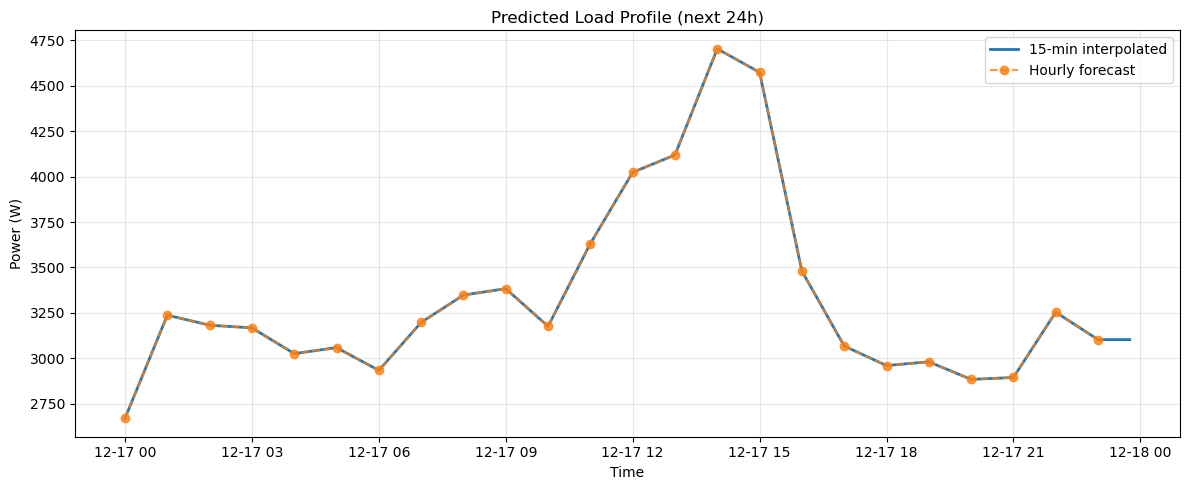

Forecast energy next 24h: 80.21 kWh


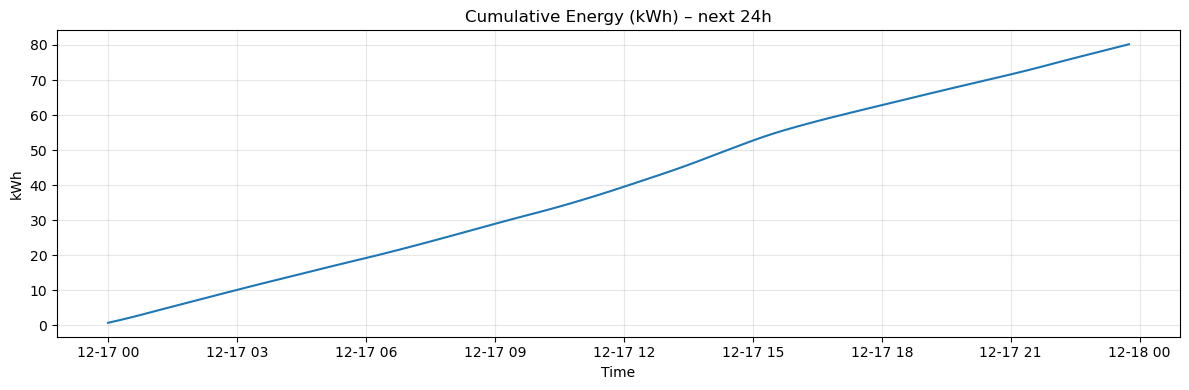

In [5]:
# 15-min interpolation
new_index = pd.date_range(start=forecast_24h.index[0], periods=96, freq="15min")

forecast_15min = forecast_24h.reindex(new_index).interpolate("linear")

# save to CSV 
forecast_15min_df = forecast_15min.reset_index()
forecast_15min_df.columns = ["timestamp", "predicted_power_W"]
forecast_15min_df.to_csv("forecast_15min_load.csv", index=False)

# ---Plot---
plt.figure(figsize=(12, 5))
plt.plot(forecast_15min.index, forecast_15min.values, label="15-min interpolated", linewidth=2)
plt.plot(forecast_24h.index, forecast_24h.values, "o--", label="Hourly forecast", alpha=0.8)
plt.title("Predicted Load Profile (next 24h)")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---Cumulative energy over next 24h---
energy_15min_kWh = (forecast_15min * 0.25 / 1000.0)   # W * h / 1000 -> kWh
cum_energy_kWh = energy_15min_kWh.cumsum()

print(f"Forecast energy next 24h: {energy_15min_kWh.sum():.2f} kWh")

plt.figure(figsize=(12, 4))
plt.plot(cum_energy_kWh.index, cum_energy_kWh.values)
plt.title("Cumulative Energy (kWh) – next 24h")
plt.xlabel("Time")
plt.ylabel("kWh")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Predicted load of the next day saved in a new csv file

In [6]:
df_load = forecast_15min.rename("Pin_pred_W").reset_index()
df_load.columns = ["Time", "Pin_pred_W"] 

# Save with Time column
df_load.to_csv("predicted_load_24h.csv", index=False)
print("Saved predicted_load_24h.csv with Time + Pin_pred_W")


Saved predicted_load_24h.csv with Time + Pin_pred_W
